In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import norm
import time

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans', 'Arial Unicode MS', 'Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False


class NonconvexConstrainedSolver:
    """
    非凸约束优化问题求解器基类
    
    优化问题:
        minimize  (1/2)||Lx - y||² + Σ p(xᵢ)  (非凸目标)
        subject to  x ≥ 0                      (非负约束)
                    ||x||₂ ≤ M                 (能量约束)
    """
    
    def __init__(self, leadfield, measurements, energy_bound=None):
        """
        Parameters:
        -----------
        leadfield: ndarray, shape (m, n)
        measurements: ndarray, shape (m,)
        energy_bound: float, L2范数上界（None则自动设置）
        """
        self.L = leadfield
        self.y = measurements
        self.m, self.n = leadfield.shape
        
        # 预计算
        self.LTL = self.L.T @ self.L
        self.LTy = self.L.T @ self.y
        
        # 能量约束上界
        if energy_bound is None:
            # 自动设置为无约束L2解的范数
            x_l2 = np.linalg.lstsq(self.L, self.y, rcond=None)[0]
            self.M = 2.0 * norm(x_l2)
        else:
            self.M = energy_bound
            
        print(f"约束条件: x ≥ 0, ||x||₂ ≤ {self.M:.4f}")
    
    def project_feasible(self, x):
        """投影到可行域 {x ≥ 0, ||x||₂ ≤ M}"""
        # 1. 非负投影
        x = np.maximum(x, 0)
        
        # 2. L2球投影
        x_norm = norm(x)
        if x_norm > self.M:
            x = x * (self.M / x_norm)
            
        return x
    
    def scad_penalty(self, t, lambda_reg, a=3.7):
        """
        SCAD惩罚函数（非凸）
        
        Parameters:
        -----------
        t: float or array, 输入值
        lambda_reg: float, 正则化参数
        a: float, SCAD参数（通常取3.7）
        
        Returns:
        --------
        penalty: SCAD惩罚值
        """
        t_abs = np.abs(t)
        penalty = np.zeros_like(t_abs)
        
        # 区间1: |t| ≤ λ
        mask1 = t_abs <= lambda_reg
        penalty[mask1] = lambda_reg * t_abs[mask1]
        
        # 区间2: λ < |t| ≤ aλ
        mask2 = (t_abs > lambda_reg) & (t_abs <= a * lambda_reg)
        penalty[mask2] = (-(t_abs[mask2]**2 - 2*a*lambda_reg*t_abs[mask2] + lambda_reg**2) / 
                          (2*(a-1)))
        
        # 区间3: |t| > aλ
        mask3 = t_abs > a * lambda_reg
        penalty[mask3] = (a + 1) * lambda_reg**2 / 2
        
        return np.sum(penalty)
    
    def scad_derivative(self, x, lambda_reg, a=3.7):
        """
        SCAD的次梯度（subdifferential）
        
        用于DC分解: SCAD = g(x) - h(x)
        这里计算的是g(x)的次梯度
        """
        x_abs = np.abs(x)
        deriv = np.zeros_like(x)
        
        # 区间1: |x| ≤ λ
        mask1 = x_abs <= lambda_reg
        deriv[mask1] = lambda_reg * np.sign(x[mask1])
        
        # 区间2: λ < |x| ≤ aλ
        mask2 = (x_abs > lambda_reg) & (x_abs <= a * lambda_reg)
        deriv[mask2] = (a * lambda_reg - x_abs[mask2]) / (a - 1) * np.sign(x[mask2])
        
        # 区间3: |x| > aλ（导数为0）
        # deriv[mask3] = 0 已经初始化为0
        
        return deriv
    
    def compute_objective(self, x, lambda_reg, a=3.7):
        """计算目标函数值"""
        data_fit = 0.5 * norm(self.L @ x - self.y)**2
        reg_term = self.scad_penalty(x, lambda_reg, a)
        return data_fit + reg_term


class DCProjectionSolver(NonconvexConstrainedSolver):
    """
    DC算法 + 投影梯度法
    
    DC (Difference of Convex) 分解:
        SCAD(x) = g(x) - h(x)
        其中 g, h 都是凸函数
    
    算法流程:
        1. 线性化 h(x) ≈ h(x^k) + ∇h(x^k)ᵀ(x - x^k)
        2. 求解凸子问题: min g(x) - ∇h(x^k)ᵀx + 约束
        3. 投影梯度下降
        4. 投影到可行域
    """
    
    def __init__(self, leadfield, measurements, energy_bound=None):
        super().__init__(leadfield, measurements, energy_bound)
    
    def solve(self, lambda_reg=0.01, a=3.7, max_iter=200, tol=1e-4, 
              step_size=None, verbose=True):
        """
        DC算法求解
        
        Parameters:
        -----------
        lambda_reg: float, SCAD正则化参数
        a: float, SCAD参数
        max_iter: int, 最大迭代次数
        step_size: float, 步长（None则自动选择）
        """
        # 步长选择
        if step_size is None:
            L_lip = norm(self.LTL, 2)
            step_size = 0.5 / L_lip
        
        # 初始化（用L1-ADMM warm start）
        print("使用L1-ADMM进行warm start初始化...")
        x = self._warm_start_l1(lambda_reg)
        x = self.project_feasible(x)
        
        # 记录历史
        history = {
            'objective': [],
            'residual': [],
            'feasibility': [],
            'time': []
        }
        
        start_time = time.time()
        
        if verbose:
            print("\n" + "="*60)
            print("DC投影梯度算法求解中...")
            print(f"参数: λ={lambda_reg}, a={a}, 步长={step_size:.4e}")
            print("="*60)
        
        for k in range(max_iter):
            x_old = x.copy()
            
            # 1. 计算数据拟合项的梯度
            grad_data = self.L.T @ (self.L @ x - self.y)
            
            # 2. 计算SCAD的次梯度（DC中的g'(x) - h'(x)）
            grad_scad = self.scad_derivative(x, lambda_reg, a)
            
            # 3. 梯度下降步
            x = x - step_size * (grad_data + grad_scad)
            
            # 4. 投影到可行域 {x ≥ 0, ||x||₂ ≤ M}
            x = self.project_feasible(x)
            
            # 计算指标
            obj = self.compute_objective(x, lambda_reg, a)
            res = norm(self.L @ x - self.y)
            feasibility = self._check_feasibility(x)
            
            history['objective'].append(obj)
            history['residual'].append(res)
            history['feasibility'].append(feasibility)
            history['time'].append(time.time() - start_time)
            
            # 检查收敛
            rel_change = norm(x - x_old) / (norm(x) + 1e-10)
            
            if verbose and k % 20 == 0:
                print(f"Iter {k:3d}: obj={obj:.4e}, res={res:.4e}, "
                      f"feasible={feasibility:.4e}, rel_change={rel_change:.4e}")
            
            if rel_change < tol:
                if verbose:
                    print(f"\n✓ 收敛于第 {k} 次迭代")
                break
        
        if verbose:
            self._print_summary(x, history, lambda_reg, a)
        
        return x, history
    
    def _warm_start_l1(self, lambda_reg):
        """使用L1-ADMM warm start"""
        from scipy.optimize import minimize
        
        # 简单的L1投影梯度
        x = np.zeros(self.n)
        step = 0.01 / norm(self.LTL, 2)
        
        for _ in range(50):
            grad = self.L.T @ (self.L @ x - self.y)
            x = x - step * grad
            # 软阈值
            x = np.sign(x) * np.maximum(np.abs(x) - step * lambda_reg, 0)
            x = self.project_feasible(x)
        
        return x
    
    def _check_feasibility(self, x):
        """检查约束违反程度"""
        violation = 0.0
        
        # 非负约束
        violation += np.sum(np.maximum(-x, 0))
        
        # L2约束
        x_norm = norm(x)
        if x_norm > self.M:
            violation += x_norm - self.M
        
        return violation
    
    def _print_summary(self, x, history, lambda_reg, a):
        """打印求解总结"""
        print(f"\n总用时: {history['time'][-1]:.2f}秒")
        print(f"最终目标函数值: {history['objective'][-1]:.4e}")
        print(f"数据拟合残差: {history['residual'][-1]:.4e}")
        print(f"约束可行性: {history['feasibility'][-1]:.4e}")
        print(f"稀疏度: {np.sum(np.abs(x) > 1e-3)}/{self.n} "
              f"({100*np.sum(np.abs(x) > 1e-3)/self.n:.2f}%)")
        print(f"解的L2范数: {norm(x):.4f} (约束: ≤{self.M:.4f})")
        print(f"非负性检查: min(x)={np.min(x):.4e}")
        print("="*60)


class AugmentedLagrangianSolver(NonconvexConstrainedSolver):
    """
    增广拉格朗日法 (Augmented Lagrangian Method)
    
    增广拉格朗日函数:
        L(x, μ, ρ) = f(x) + μᵀc(x) + (ρ/2)||c(x)||²
        
    其中:
        f(x) = (1/2)||Lx-y||² + Σ SCAD(xᵢ)
        c(x) = [max(-x, 0); max(||x||₂-M, 0)]  约束违反
        μ: 拉格朗日乘子
        ρ: 惩罚参数
    
    算法流程:
        1. x-update: 最小化增广拉格朗日函数
        2. μ-update: 更新拉格朗日乘子
        3. ρ-update: 自适应调整惩罚参数
    """
    
    def __init__(self, leadfield, measurements, energy_bound=None):
        super().__init__(leadfield, measurements, energy_bound)
    
    def solve(self, lambda_reg=0.01, a=3.7, max_iter=50, inner_iter=30,
              rho_init=1.0, tol=1e-4, verbose=True):
        """
        增广拉格朗日法求解
        
        Parameters:
        -----------
        lambda_reg: float, SCAD参数
        rho_init: float, 初始惩罚参数
        inner_iter: int, 内层迭代次数
        max_iter: int, 外层最大迭代（减少到50）
        """
        # 初始化
        x = self._warm_start_l1(lambda_reg)
        x = self.project_feasible(x)
        
        # 拉格朗日乘子（分别对应非负约束和L2约束）
        mu_nonneg = np.zeros(self.n)
        mu_norm = 0.0
        
        rho = rho_init
        
        # 记录历史
        history = {
            'objective': [],
            'residual': [],
            'feasibility': [],
            'penalty': [],
            'time': []
        }
        
        start_time = time.time()
        
        if verbose:
            print("\n" + "="*60)
            print("增广拉格朗日法求解中...")
            print(f"参数: λ={lambda_reg}, a={a}, ρ₀={rho_init}")
            print(f"提示: 每次外层迭代需要{inner_iter}步内层优化...")
            print("="*60)
        
        for k in range(max_iter):
            x_old = x.copy()
            
            if verbose and k == 0:
                print(f"开始第 {k} 次迭代（内层优化中...）", end='', flush=True)
            
            # 1. x-update: 最小化增广拉格朗日函数（内层迭代）
            x = self._minimize_augmented_lagrangian(
                x, mu_nonneg, mu_norm, rho, lambda_reg, a, inner_iter
            )
            
            if verbose and k == 0:
                print(" 完成")
            
            # 2. 计算约束违反
            c_nonneg = np.maximum(-x, 0)  # 非负约束违反
            x_norm = norm(x)
            c_norm = max(x_norm - self.M, 0)  # L2约束违反
            
            # 3. μ-update: 更新拉格朗日乘子
            mu_nonneg = np.maximum(mu_nonneg + rho * c_nonneg, 0)  # 保持非负
            mu_norm = max(mu_norm + rho * c_norm, 0)
            
            # 4. ρ-update: 自适应调整惩罚参数
            constraint_violation = norm(c_nonneg) + abs(c_norm)
            prev_feasibility = self._check_feasibility(x_old)
            
            if constraint_violation > 0.25 * prev_feasibility:
                rho = min(rho * 1.5, 1e5)  # 更温和地增加惩罚
            
            # 计算指标
            obj = self.compute_objective(x, lambda_reg, a)
            res = norm(self.L @ x - self.y)
            feasibility = self._check_feasibility(x)
            
            history['objective'].append(obj)
            history['residual'].append(res)
            history['feasibility'].append(feasibility)
            history['penalty'].append(rho)
            history['time'].append(time.time() - start_time)
            
            # 检查收敛
            rel_change = norm(x - x_old) / (norm(x) + 1e-10)
            
            if verbose and k % 5 == 0:
                print(f"Iter {k:3d}: obj={obj:.4e}, res={res:.4e}, "
                      f"feasible={feasibility:.4e}, ρ={rho:.2e}, change={rel_change:.4e}")
            
            if rel_change < tol and feasibility < 1e-3:
                if verbose:
                    print(f"\n✓ 收敛于第 {k} 次迭代")
                break
        
        if verbose:
            self._print_summary(x, history, lambda_reg, a)
        
        return x, history
    
    def _minimize_augmented_lagrangian(self, x0, mu_nonneg, mu_norm, rho, 
                                       lambda_reg, a, max_inner_iter):
        """
        最小化增广拉格朗日函数（内层问题）
        使用加速的投影梯度法
        """
        x = x0.copy()
        
        # 自适应步长：更大的初始步长
        L_lip = norm(self.LTL, 2) + rho
        step_size = 1.0 / L_lip
        
        # Nesterov加速
        y = x.copy()
        t = 1.0
        
        for iter_inner in range(max_inner_iter):
            x_old = x.copy()
            
            # 梯度：数据项 + SCAD + 增广拉格朗日项
            grad_data = self.L.T @ (self.L @ y - self.y)
            grad_scad = self.scad_derivative(y, lambda_reg, a)
            
            # 增广拉格朗日梯度（简化版，只对违反约束的部分惩罚）
            grad_aug = np.zeros_like(y)
            
            # 非负约束的梯度
            mask_negative = y < 0
            if np.any(mask_negative):
                grad_aug[mask_negative] = -(mu_nonneg[mask_negative] + 
                                           rho * y[mask_negative])
            
            # L2约束的梯度
            y_norm = norm(y)
            if y_norm > self.M:
                grad_aug += (mu_norm + rho * (y_norm - self.M)) * y / y_norm
            
            # 总梯度
            grad_total = grad_data + grad_scad + grad_aug
            
            # 梯度下降
            x = y - step_size * grad_total
            
            # 强制投影到可行域
            x = self.project_feasible(x)
            
            # Nesterov加速更新
            t_new = (1 + np.sqrt(1 + 4 * t**2)) / 2
            y = x + ((t - 1) / t_new) * (x - x_old)
            t = t_new
            
            # 早停：如果内层已经收敛
            if iter_inner > 5 and norm(x - x_old) < 1e-5 * (norm(x) + 1e-10):
                break
        
        return x
    
    def _warm_start_l1(self, lambda_reg):
        """L1 warm start"""
        x = np.zeros(self.n)
        step = 0.01 / norm(self.LTL, 2)
        
        for _ in range(50):
            grad = self.L.T @ (self.L @ x - self.y)
            x = x - step * grad
            x = np.sign(x) * np.maximum(np.abs(x) - step * lambda_reg, 0)
            x = self.project_feasible(x)
        
        return x
    
    def _check_feasibility(self, x):
        """检查约束违反"""
        violation = np.sum(np.maximum(-x, 0))
        x_norm = norm(x)
        if x_norm > self.M:
            violation += x_norm - self.M
        return violation
    
    def _print_summary(self, x, history, lambda_reg, a):
        """打印总结"""
        print(f"\n总用时: {history['time'][-1]:.2f}秒")
        print(f"最终目标函数值: {history['objective'][-1]:.4e}")
        print(f"数据拟合残差: {history['residual'][-1]:.4e}")
        print(f"约束可行性: {history['feasibility'][-1]:.4e}")
        print(f"最终惩罚参数: {history['penalty'][-1]:.2e}")
        print(f"稀疏度: {np.sum(np.abs(x) > 1e-3)}/{self.n} "
              f"({100*np.sum(np.abs(x) > 1e-3)/self.n:.2f}%)")
        print(f"解的L2范数: {norm(x):.4f} (约束: ≤{self.M:.4f})")
        print(f"非负性检查: min(x)={np.min(x):.4e}")
        print("="*60)


# ===== 辅助函数 =====

def compare_nonconvex_methods(leadfield, measurements, x_true, lambda_reg=0.01):
    """对比两种非凸优化方法"""
    
    print("\n" + "="*70)
    print("非凸约束优化问题对比")
    print("="*70)
    print("问题形式:")
    print("  minimize  (1/2)||Lx - y||² + Σ SCAD(xᵢ)")
    print("  subject to  x ≥ 0, ||x||₂ ≤ M")
    print("="*70 + "\n")
    
    # 方法1: DC投影梯度
    print("【方法1】DC投影梯度法")
    dc_solver = DCProjectionSolver(leadfield, measurements)
    x_dc, hist_dc = dc_solver.solve(lambda_reg=lambda_reg, max_iter=200)
    
    print("\n")
    
    # 方法2: 增广拉格朗日法（减少迭代次数）
    print("【方法2】增广拉格朗日法")
    al_solver = AugmentedLagrangianSolver(leadfield, measurements)
    x_al, hist_al = al_solver.solve(lambda_reg=lambda_reg, max_iter=30, inner_iter=30)
    
    # 性能对比
    _print_comparison(x_true, x_dc, x_al, hist_dc, hist_al)
    
    return {
        'x_dc': x_dc,
        'x_al': x_al,
        'hist_dc': hist_dc,
        'hist_al': hist_al,
        'lambda_reg': lambda_reg
    }


def _print_comparison(x_true, x_dc, x_al, hist_dc, hist_al):
    """打印性能对比"""
    # 重建误差
    error_dc = norm(x_dc - x_true) / (norm(x_true) + 1e-10)
    error_al = norm(x_al - x_true) / (norm(x_true) + 1e-10)
    
    # 定位精度
    peak_true = np.argmax(np.abs(x_true))
    peak_dc = np.argmax(np.abs(x_dc))
    peak_al = np.argmax(np.abs(x_al))
    
    pos_error_dc = abs(peak_dc - peak_true)
    pos_error_al = abs(peak_al - peak_true)
    
    # 能量恢复
    energy_true = np.sum(x_true**2)
    energy_dc = np.sum(x_dc**2)
    energy_al = np.sum(x_al**2)
    
    print("\n" + "="*70)
    print("性能对比总结")
    print("="*70)
    print("\n【重建误差】")
    print(f"  DC投影梯度法:    {error_dc:.4f}")
    print(f"  增广拉格朗日法:  {error_al:.4f}")
    
    print("\n【定位精度】(峰值位置偏差)")
    print(f"  真实峰值位置:  {peak_true}")
    print(f"  DC法定位:      {peak_dc}  (偏差: {pos_error_dc} 个源点)")
    print(f"  ALM法定位:     {peak_al}  (偏差: {pos_error_al} 个源点)")
    
    print("\n【能量恢复】")
    print(f"  DC法:   {energy_dc/energy_true:.4f}  ({energy_dc/energy_true*100:.2f}%)")
    print(f"  ALM法:  {energy_al/energy_true:.4f}  ({energy_al/energy_true*100:.2f}%)")
    
    print("\n【计算时间】")
    print(f"  DC法:   {hist_dc['time'][-1]:.2f}秒")
    print(f"  ALM法:  {hist_al['time'][-1]:.2f}秒")
    
    print("="*70)


def visualize_nonconvex_results(x_true, results, measurements, leadfield):
    """
    可视化非凸优化结果
    
    Parameters:
    -----------
    x_true: 真实源信号
    results: compare_nonconvex_methods的返回字典
    measurements: 头皮电位测量
    leadfield: 导联场矩阵
    """
    x_dc = results['x_dc']
    x_al = results['x_al']
    hist_dc = results['hist_dc']
    hist_al = results['hist_al']
    
    fig = plt.figure(figsize=(20, 14))
    
    # 找峰值位置
    peak_true = np.argmax(np.abs(x_true))
    peak_dc = np.argmax(np.abs(x_dc))
    peak_al = np.argmax(np.abs(x_al))
    
    window = 200
    start_idx = max(0, peak_true - window)
    end_idx = min(len(x_true), peak_true + window)
    idx_range = np.arange(start_idx, end_idx)
    
    # ===== 第1行: 全局源信号对比 =====
    ax1 = plt.subplot(4, 4, 1)
    ax1.plot(x_true, 'k-', linewidth=2, label='真实源', alpha=0.7)
    ax1.axvline(peak_true, color='k', linestyle='--', alpha=0.3)
    ax1.set_xlabel('源空间索引')
    ax1.set_ylabel('电流密度')
    ax1.set_title('真实源信号（全局）')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    ax2 = plt.subplot(4, 4, 2)
    ax2.plot(x_dc, 'b-', linewidth=1.5, label='DC法', alpha=0.7)
    ax2.axvline(peak_dc, color='b', linestyle='--', alpha=0.5)
    ax2.axvline(peak_true, color='k', linestyle=':', alpha=0.3)
    ax2.set_xlabel('源空间索引')
    ax2.set_ylabel('电流密度')
    ax2.set_title(f'DC投影梯度法（偏差: {abs(peak_dc-peak_true)}）')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    ax3 = plt.subplot(4, 4, 3)
    ax3.plot(x_al, 'r-', linewidth=1.5, label='ALM法', alpha=0.7)
    ax3.axvline(peak_al, color='r', linestyle='--', alpha=0.5)
    ax3.axvline(peak_true, color='k', linestyle=':', alpha=0.3)
    ax3.set_xlabel('源空间索引')
    ax3.set_ylabel('电流密度')
    ax3.set_title(f'增广拉格朗日法（偏差: {abs(peak_al-peak_true)}）')
    ax3.grid(True, alpha=0.3)
    ax3.legend()
    
    # SCAD惩罚函数可视化
    ax4 = plt.subplot(4, 4, 4)
    t = np.linspace(-5, 5, 1000)
    lambda_reg = results['lambda_reg']
    a = 3.7
    
    # L1惩罚（对比）
    penalty_l1 = lambda_reg * np.abs(t)
    
    # SCAD惩罚
    penalty_scad = np.zeros_like(t)
    for i, ti in enumerate(t):
        t_abs = abs(ti)
        if t_abs <= lambda_reg:
            penalty_scad[i] = lambda_reg * t_abs
        elif t_abs <= a * lambda_reg:
            penalty_scad[i] = -(t_abs**2 - 2*a*lambda_reg*t_abs + lambda_reg**2) / (2*(a-1))
        else:
            penalty_scad[i] = (a + 1) * lambda_reg**2 / 2
    
    ax4.plot(t, penalty_l1, 'g--', linewidth=2, label='L1惩罚（凸）', alpha=0.7)
    ax4.plot(t, penalty_scad, 'r-', linewidth=2, label='SCAD惩罚（非凸）', alpha=0.8)
    ax4.axvline(lambda_reg, color='gray', linestyle=':', alpha=0.5)
    ax4.axvline(a*lambda_reg, color='gray', linestyle=':', alpha=0.5)
    ax4.set_xlabel('|x|')
    ax4.set_ylabel('惩罚值')
    ax4.set_title(f'SCAD vs L1惩罚函数对比（λ={lambda_reg:.3f}）')
    ax4.grid(True, alpha=0.3)
    ax4.legend()
    
    # ===== 第2行: 局部放大对比 =====
    ax5 = plt.subplot(4, 4, 5)
    ax5.plot(idx_range, x_true[start_idx:end_idx], 'k-', linewidth=2.5, 
             label='真实源', alpha=0.8)
    ax5.axvline(peak_true, color='k', linestyle='--', alpha=0.3)
    ax5.set_xlabel('源空间索引')
    ax5.set_ylabel('电流密度')
    ax5.set_title(f'真实源局部（±{window}点）')
    ax5.grid(True, alpha=0.3)
    ax5.legend()
    
    ax6 = plt.subplot(4, 4, 6)
    ax6.plot(idx_range, x_true[start_idx:end_idx], 'k-', linewidth=2, 
             label='真实', alpha=0.4)
    ax6.plot(idx_range, x_dc[start_idx:end_idx], 'b-', linewidth=2, 
             label='DC重建', alpha=0.8)
    ax6.axvline(peak_true, color='k', linestyle='--', alpha=0.3)
    ax6.axvline(peak_dc, color='b', linestyle='--', alpha=0.5)
    ax6.set_xlabel('源空间索引')
    ax6.set_ylabel('电流密度')
    ax6.set_title('DC法局部对比')
    ax6.grid(True, alpha=0.3)
    ax6.legend()
    
    ax7 = plt.subplot(4, 4, 7)
    ax7.plot(idx_range, x_true[start_idx:end_idx], 'k-', linewidth=2, 
             label='真实', alpha=0.4)
    ax7.plot(idx_range, x_al[start_idx:end_idx], 'r-', linewidth=2, 
             label='ALM重建', alpha=0.8)
    ax7.axvline(peak_true, color='k', linestyle='--', alpha=0.3)
    ax7.axvline(peak_al, color='r', linestyle='--', alpha=0.5)
    ax7.set_xlabel('源空间索引')
    ax7.set_ylabel('电流密度')
    ax7.set_title('ALM法局部对比')
    ax7.grid(True, alpha=0.3)
    ax7.legend()
    
    # 三方法叠加对比
    ax8 = plt.subplot(4, 4, 8)
    ax8.plot(idx_range, x_true[start_idx:end_idx], 'k-', linewidth=2.5, 
             label='真实', alpha=0.6)
    ax8.plot(idx_range, x_dc[start_idx:end_idx], 'b-', linewidth=1.5, 
             label='DC法', alpha=0.7)
    ax8.plot(idx_range, x_al[start_idx:end_idx], 'r-', linewidth=1.5, 
             label='ALM法', alpha=0.7)
    ax8.set_xlabel('源空间索引')
    ax8.set_ylabel('电流密度')
    ax8.set_title('三方法局部叠加对比')
    ax8.grid(True, alpha=0.3)
    ax8.legend()
    
    # ===== 第3行: 收敛性分析 =====
    ax9 = plt.subplot(4, 4, 9)
    ax9.semilogy(hist_dc['objective'], 'b-', linewidth=2, label='DC法')
    ax9.semilogy(hist_al['objective'], 'r-', linewidth=2, label='ALM法')
    ax9.set_xlabel('迭代次数')
    ax9.set_ylabel('目标函数值 (log)')
    ax9.set_title('收敛曲线：目标函数')
    ax9.grid(True, alpha=0.3)
    ax9.legend()
    
    ax10 = plt.subplot(4, 4, 10)
    ax10.semilogy(hist_dc['residual'], 'b-', linewidth=2, label='DC法')
    ax10.semilogy(hist_al['residual'], 'r-', linewidth=2, label='ALM法')
    ax10.set_xlabel('迭代次数')
    ax10.set_ylabel('数据拟合残差 (log)')
    ax10.set_title('收敛曲线：残差')
    ax10.grid(True, alpha=0.3)
    ax10.legend()
    
    ax11 = plt.subplot(4, 4, 11)
    ax11.semilogy(hist_dc['feasibility'], 'b-', linewidth=2, label='DC法')
    ax11.semilogy(hist_al['feasibility'], 'r-', linewidth=2, label='ALM法')
    ax11.axhline(1e-4, color='gray', linestyle='--', alpha=0.5, label='容忍度')
    ax11.set_xlabel('迭代次数')
    ax11.set_ylabel('约束违反 (log)')
    ax11.set_title('收敛曲线：约束可行性')
    ax11.grid(True, alpha=0.3)
    ax11.legend()
    
    ax12 = plt.subplot(4, 4, 12)
    ax12.semilogy(hist_dc['time'], hist_dc['objective'], 'b-', linewidth=2, label='DC法')
    ax12.semilogy(hist_al['time'], hist_al['objective'], 'r-', linewidth=2, label='ALM法')
    ax12.set_xlabel('时间 (秒)')
    ax12.set_ylabel('目标函数值 (log)')
    ax12.set_title('时间效率对比')
    ax12.grid(True, alpha=0.3)
    ax12.legend()
    
    # ===== 第4行: 性能指标对比 =====
    # 头皮电位拟合
    y_true = leadfield @ x_true
    y_dc = leadfield @ x_dc
    y_al = leadfield @ x_al
    
    ax13 = plt.subplot(4, 4, 13)
    ax13.plot(measurements, 'ko-', markersize=5, label='测量值', alpha=0.7)
    ax13.plot(y_dc, 'b^-', markersize=4, label='DC拟合', alpha=0.7)
    ax13.plot(y_al, 'rs-', markersize=4, label='ALM拟合', alpha=0.7)
    ax13.set_xlabel('电极索引')
    ax13.set_ylabel('电位')
    ax13.set_title('头皮电位拟合对比')
    ax13.grid(True, alpha=0.3)
    ax13.legend()
    
    # 稀疏性对比
    threshold = 1e-3
    sparsity_true = np.sum(np.abs(x_true) > threshold)
    sparsity_dc = np.sum(np.abs(x_dc) > threshold)
    sparsity_al = np.sum(np.abs(x_al) > threshold)
    
    ax14 = plt.subplot(4, 4, 14)
    methods = ['真实', 'DC法', 'ALM法']
    sparsities = [sparsity_true, sparsity_dc, sparsity_al]
    colors = ['black', 'blue', 'red']
    bars = ax14.bar(methods, sparsities, color=colors, alpha=0.7)
    ax14.set_ylabel('非零元素数量')
    ax14.set_title('稀疏性对比')
    ax14.grid(True, alpha=0.3, axis='y')
    for bar in bars:
        height = bar.get_height()
        ax14.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}', ha='center', va='bottom')
    
    # 约束满足情况
    ax15 = plt.subplot(4, 4, 15)
    
    # 非负性
    min_vals = [np.min(x_true), np.min(x_dc), np.min(x_al)]
    ax15_twin = ax15.twinx()
    
    bars1 = ax15.bar([0, 1, 2], [norm(x_true), norm(x_dc), norm(x_al)], 
                     width=0.4, color=colors, alpha=0.7, label='L2范数')
    ax15.axhline(x_dc.shape[0]**0.5, color='gray', linestyle='--', 
                alpha=0.5, label='能量上界')
    ax15.set_ylabel('L2范数')
    ax15.set_xticks([0, 1, 2])
    ax15.set_xticklabels(methods)
    ax15.set_title('约束满足情况')
    ax15.legend(loc='upper left')
    
    bars2 = ax15_twin.bar([0.4, 1.4, 2.4], min_vals, width=0.4, 
                          color=colors, alpha=0.5, label='最小值')
    ax15_twin.axhline(0, color='red', linestyle='--', alpha=0.5)
    ax15_twin.set_ylabel('最小值（非负性）')
    ax15_twin.legend(loc='upper right')
    ax15.grid(True, alpha=0.3, axis='y')
    
    # 误差分布
    ax16 = plt.subplot(4, 4, 16)
    error_dc = np.abs(x_dc - x_true)
    error_al = np.abs(x_al - x_true)
    ax16.plot(idx_range, error_dc[start_idx:end_idx], 'b-', linewidth=2, 
             label='DC误差', alpha=0.7)
    ax16.plot(idx_range, error_al[start_idx:end_idx], 'r-', linewidth=2, 
             label='ALM误差', alpha=0.7)
    ax16.axvline(peak_true, color='k', linestyle='--', alpha=0.3)
    ax16.set_xlabel('源空间索引')
    ax16.set_ylabel('绝对误差')
    ax16.set_title('重建误差分布（局部）')
    ax16.grid(True, alpha=0.3)
    ax16.legend()
    
    plt.tight_layout()
    plt.show()


def plot_scad_properties(lambda_reg=0.01, a=3.7):
    """单独绘制SCAD惩罚函数性质"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    t = np.linspace(-3, 3, 1000)
    
    # 1. 惩罚函数对比
    ax = axes[0]
    penalty_l1 = lambda_reg * np.abs(t)
    penalty_l2 = 0.5 * lambda_reg * t**2
    penalty_scad = np.zeros_like(t)
    
    for i, ti in enumerate(t):
        t_abs = abs(ti)
        if t_abs <= lambda_reg:
            penalty_scad[i] = lambda_reg * t_abs
        elif t_abs <= a * lambda_reg:
            penalty_scad[i] = -(t_abs**2 - 2*a*lambda_reg*t_abs + lambda_reg**2) / (2*(a-1))
        else:
            penalty_scad[i] = (a + 1) * lambda_reg**2 / 2
    
    ax.plot(t, penalty_l1, 'g--', linewidth=2, label='L1（凸）')
    ax.plot(t, penalty_l2, 'b:', linewidth=2, label='L2（凸）')
    ax.plot(t, penalty_scad, 'r-', linewidth=2.5, label='SCAD（非凸）')
    ax.set_xlabel('x')
    ax.set_ylabel('惩罚值 p(x)')
    ax.set_title('惩罚函数对比')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 2. 导数对比
    ax = axes[1]
    deriv_l1 = lambda_reg * np.sign(t)
    deriv_l2 = lambda_reg * t
    deriv_scad = np.zeros_like(t)
    
    for i, ti in enumerate(t):
        t_abs = abs(ti)
        if t_abs <= lambda_reg:
            deriv_scad[i] = lambda_reg * np.sign(ti)
        elif t_abs <= a * lambda_reg:
            deriv_scad[i] = (a * lambda_reg - t_abs) / (a - 1) * np.sign(ti)
        else:
            deriv_scad[i] = 0
    
    ax.plot(t, deriv_l1, 'g--', linewidth=2, label='L1导数')
    ax.plot(t, deriv_l2, 'b:', linewidth=2, label='L2导数')
    ax.plot(t, deriv_scad, 'r-', linewidth=2.5, label='SCAD导数')
    ax.set_xlabel('x')
    ax.set_ylabel("p'(x)")
    ax.set_title('惩罚导数对比（稀疏性来源）')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 3. 为什么SCAD更好
    ax = axes[2]
    x_vals = np.array([0.5, 1.5, 2.5])
    l1_penalty = lambda_reg * x_vals
    scad_penalty = []
    
    for xi in x_vals:
        if xi <= lambda_reg:
            scad_penalty.append(lambda_reg * xi)
        elif xi <= a * lambda_reg:
            scad_penalty.append(-(xi**2 - 2*a*lambda_reg*xi + lambda_reg**2) / (2*(a-1)))
        else:
            scad_penalty.append((a + 1) * lambda_reg**2 / 2)
    
    x_pos = np.arange(len(x_vals))
    width = 0.35
    
    ax.bar(x_pos - width/2, l1_penalty, width, label='L1惩罚', color='green', alpha=0.7)
    ax.bar(x_pos + width/2, scad_penalty, width, label='SCAD惩罚', color='red', alpha=0.7)
    ax.set_xlabel('系数大小')
    ax.set_ylabel('惩罚值')
    ax.set_title('大系数惩罚对比（SCAD无偏）')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(['小(0.5)', '中(1.5)', '大(2.5)'])
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()





正在计算导联场矩阵...
导联场矩阵维度: (64, 10000)
条件数: 3.68e+01 (病态矩阵，需要正则化)

测试用例: 单点源

非凸约束优化问题对比
问题形式:
  minimize  (1/2)||Lx - y||² + Σ SCAD(xᵢ)
  subject to  x ≥ 0, ||x||₂ ≤ M

【方法1】DC投影梯度法
约束条件: x ≥ 0, ||x||₂ ≤ 0.2131
使用L1-ADMM进行warm start初始化...

DC投影梯度算法求解中...
参数: λ=0.005, a=3.7, 步长=6.2811e-05
Iter   0: obj=5.5336e-01, res=1.0487e+00, feasible=0.0000e+00, rel_change=4.4881e-01
Iter  20: obj=1.8788e-01, res=6.0428e-01, feasible=0.0000e+00, rel_change=2.1865e-02
Iter  40: obj=1.3505e-01, res=5.0929e-01, feasible=0.0000e+00, rel_change=1.0790e-02
Iter  60: obj=1.1037e-01, res=4.5826e-01, feasible=0.0000e+00, rel_change=7.1725e-03
Iter  80: obj=9.5285e-02, res=4.2406e-01, feasible=0.0000e+00, rel_change=5.3720e-03
Iter 100: obj=8.4812e-02, res=3.9861e-01, feasible=0.0000e+00, rel_change=4.2996e-03
Iter 120: obj=7.6992e-02, res=3.7851e-01, feasible=0.0000e+00, rel_change=3.5779e-03
Iter 140: obj=7.0875e-02, res=3.6200e-01, feasible=0.0000e+00, rel_change=3.0690e-03
Iter 160: obj=6.5929e-02, res=3.480

C:\Users\lcy\AppData\Local\Temp\ipykernel_1820\271538509.py:715: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax11.axhline(1e-4, color='gray', linestyle='--', alpha=0.5, label='容忍度')
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a

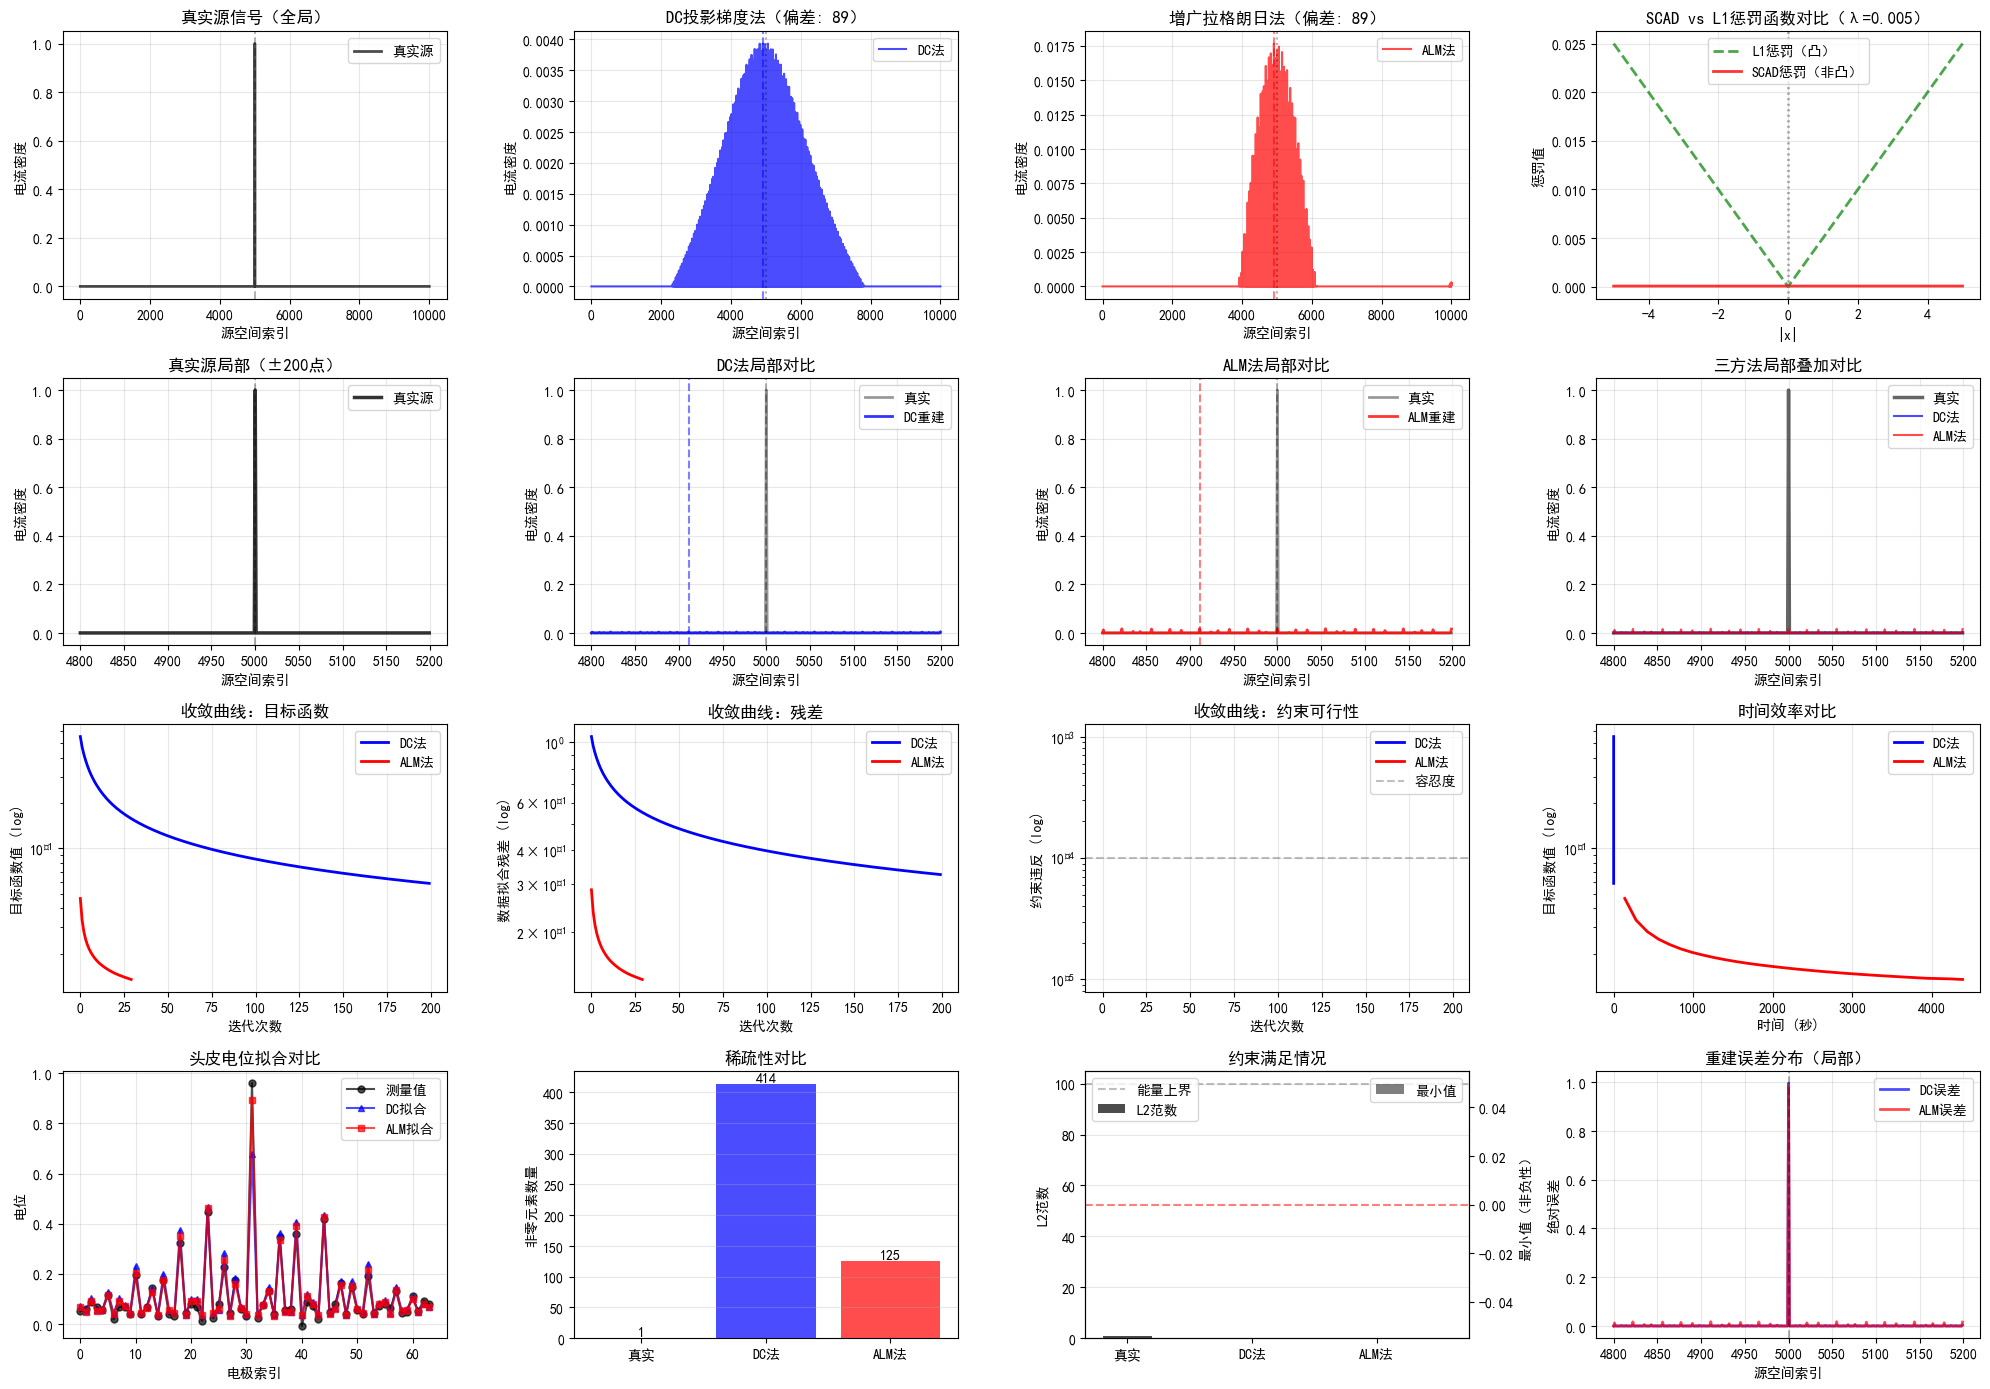


测试用例: 双点源

非凸约束优化问题对比
问题形式:
  minimize  (1/2)||Lx - y||² + Σ SCAD(xᵢ)
  subject to  x ≥ 0, ||x||₂ ≤ M

【方法1】DC投影梯度法
约束条件: x ≥ 0, ||x||₂ ≤ 0.2226
使用L1-ADMM进行warm start初始化...

DC投影梯度算法求解中...
参数: λ=0.005, a=3.7, 步长=6.2811e-05
Iter   0: obj=9.2751e-01, res=1.3574e+00, feasible=0.0000e+00, rel_change=4.4403e-01
Iter  20: obj=2.3299e-01, res=6.6881e-01, feasible=0.0000e+00, rel_change=1.7443e-02
Iter  40: obj=1.7000e-01, res=5.6681e-01, feasible=0.0000e+00, rel_change=8.7725e-03
Iter  60: obj=1.4163e-01, res=5.1433e-01, feasible=0.0000e+00, rel_change=6.0624e-03
Iter  80: obj=1.2394e-01, res=4.7872e-01, feasible=0.0000e+00, rel_change=4.7095e-03
Iter 100: obj=1.1137e-01, res=4.5169e-01, feasible=0.0000e+00, rel_change=3.8689e-03
Iter 120: obj=1.0180e-01, res=4.2999e-01, feasible=0.0000e+00, rel_change=3.2807e-03
Iter 140: obj=9.4211e-02, res=4.1197e-01, feasible=0.0000e+00, rel_change=2.8475e-03
Iter 160: obj=8.8002e-02, res=3.9662e-01, feasible=0.0000e+00, rel_change=2.5073e-03
Iter 180: o

C:\Users\lcy\AppData\Local\Temp\ipykernel_1820\271538509.py:715: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax11.axhline(1e-4, color='gray', linestyle='--', alpha=0.5, label='容忍度')
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a

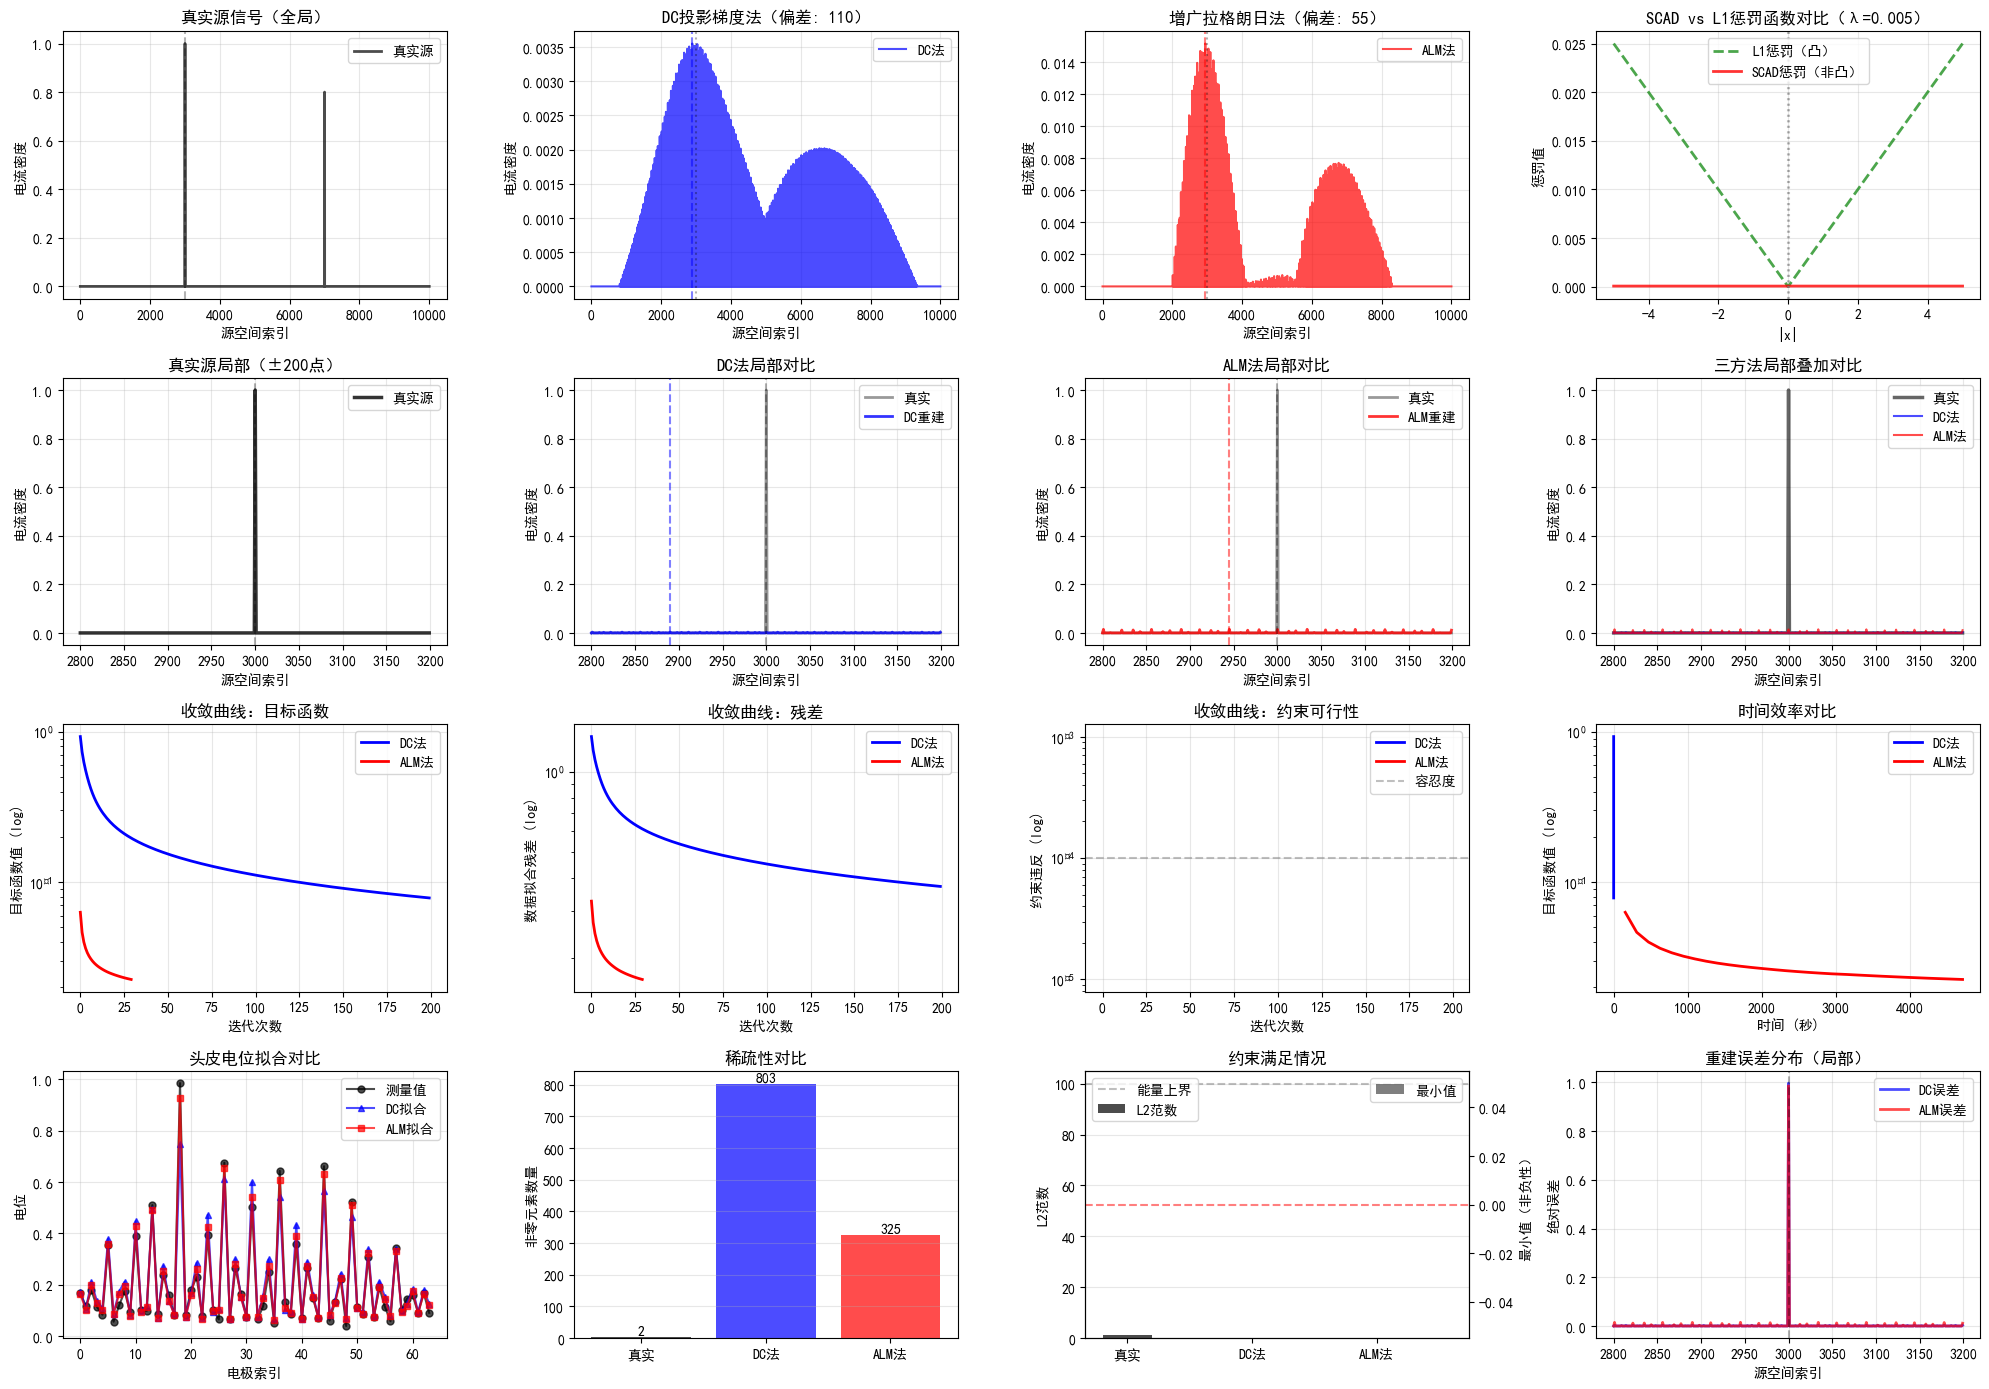


测试用例: 分布源

非凸约束优化问题对比
问题形式:
  minimize  (1/2)||Lx - y||² + Σ SCAD(xᵢ)
  subject to  x ≥ 0, ||x||₂ ≤ M

【方法1】DC投影梯度法
约束条件: x ≥ 0, ||x||₂ ≤ 176.1050
使用L1-ADMM进行warm start初始化...

DC投影梯度算法求解中...
参数: λ=0.005, a=3.7, 步长=6.2811e-05
Iter   0: obj=2.8212e+06, res=2.3754e+03, feasible=0.0000e+00, rel_change=4.3373e-01
Iter  20: obj=4.1656e+02, res=2.8844e+01, feasible=0.0000e+00, rel_change=6.4826e-04
Iter  40: obj=2.2538e+02, res=2.1203e+01, feasible=0.0000e+00, rel_change=1.1045e-04

✓ 收敛于第 44 次迭代

总用时: 0.02秒
最终目标函数值: 2.2025e+02
数据拟合残差: 2.0960e+01
约束可行性: 0.0000e+00
稀疏度: 10000/10000 (100.00%)
解的L2范数: 87.8569 (约束: ≤176.1050)
非负性检查: min(x)=7.6453e-01


【方法2】增广拉格朗日法
约束条件: x ≥ 0, ||x||₂ ≤ 176.1050

增广拉格朗日法求解中...
参数: λ=0.005, a=3.7, ρ₀=1.0
提示: 每次外层迭代需要30步内层优化...
开始第 0 次迭代（内层优化中...） 完成
Iter   0: obj=1.1026e+02, res=1.4810e+01, feasible=0.0000e+00, ρ=1.00e+00, change=6.0720e-01
Iter   5: obj=2.0168e+01, res=6.2579e+00, feasible=0.0000e+00, ρ=1.00e+00, change=3.8223e-03
Iter  10: obj=5.8904e+00, res=3

C:\Users\lcy\AppData\Local\Temp\ipykernel_1820\271538509.py:715: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax11.axhline(1e-4, color='gray', linestyle='--', alpha=0.5, label='容忍度')
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a

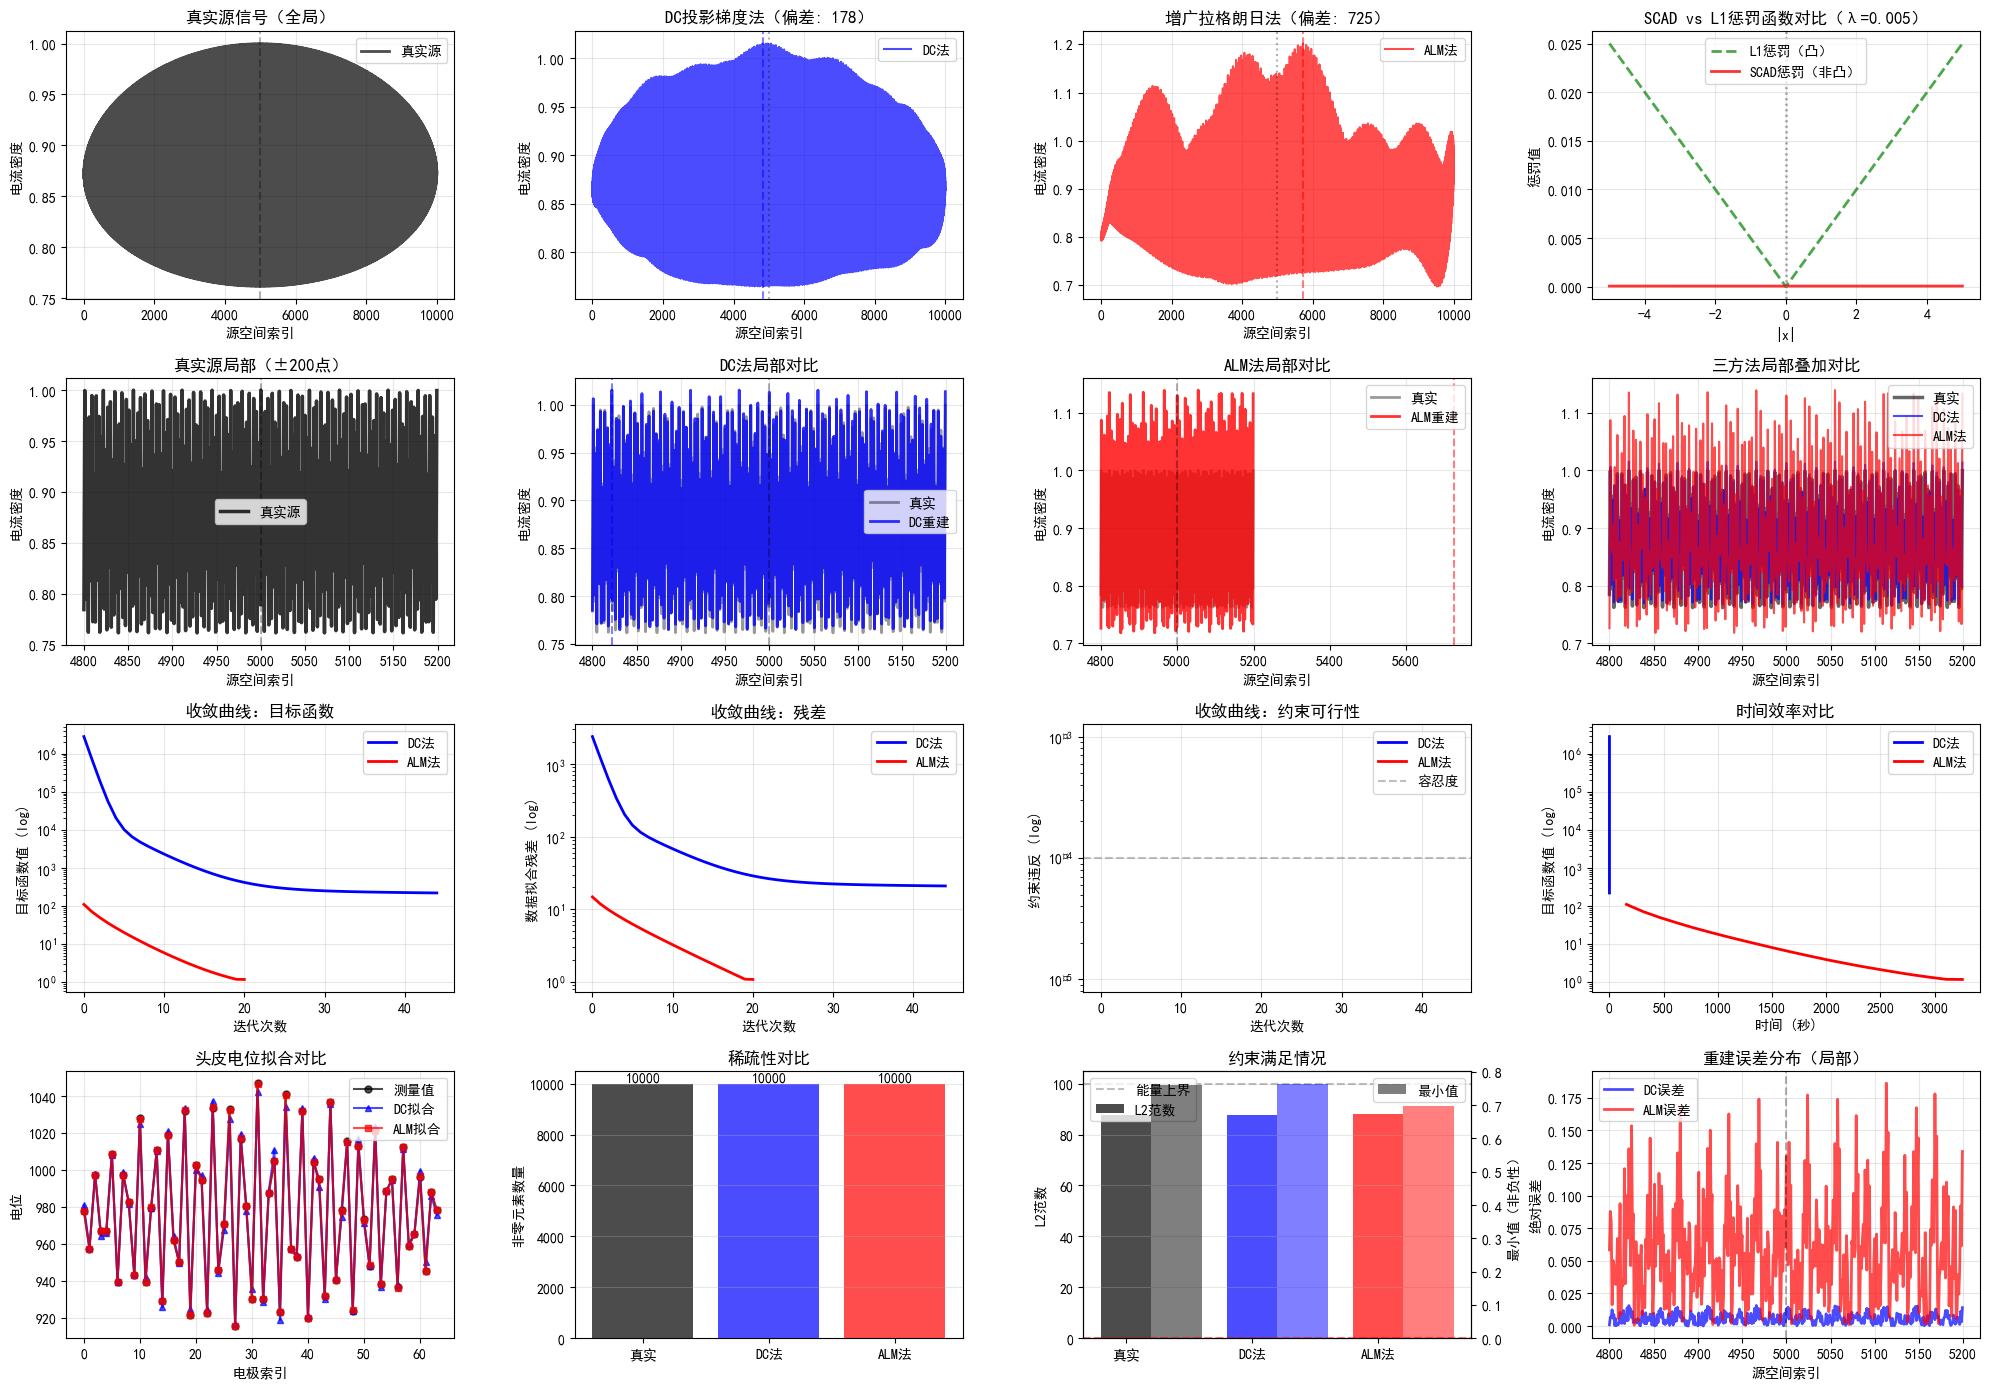

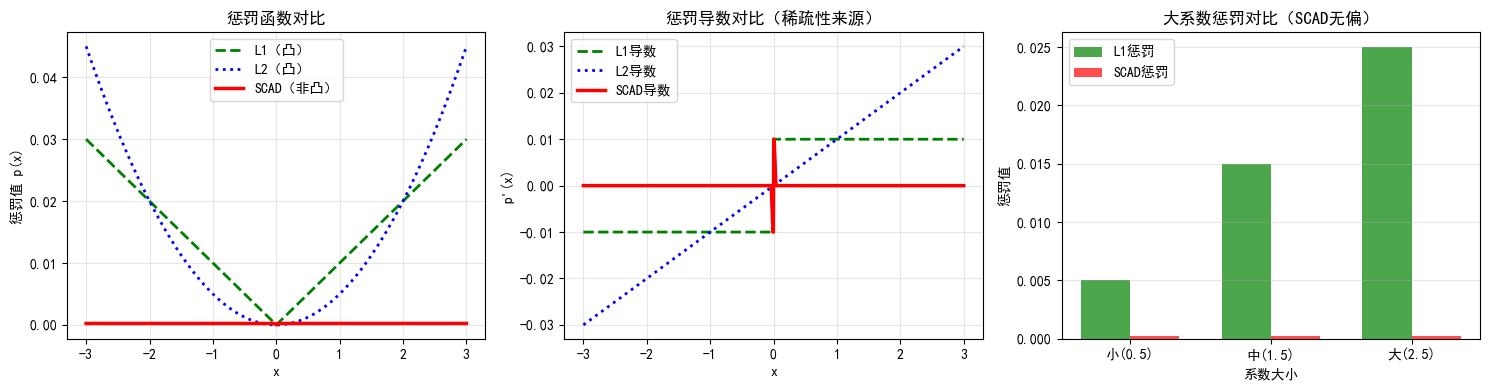

In [2]:
# 1. 导入正向模型（已有代码）
from forward_model import EEGForwardModel

# 2. 创建模型和测试数据
model = EEGForwardModel(n_channels=64, n_sources=10000)

# 3. 测试三个用例
test_cases = [
    ('单点源', model.create_point_source(5000, 1.0)),
    ('双点源', model.create_point_source([3000, 7000], [1.0, 0.8])),
    ('分布源', model.create_distributed_source(5000, width=100, amplitude=1.0))
]

for name, x_true in test_cases:
    print(f"\n{'='*70}")
    print(f"测试用例: {name}")
    print('='*70)
    
    # 生成测量数据
    y_measured = model.forward_solution(x_true, noise_level=0.1)
    
    # 运行非凸优化
    results = compare_nonconvex_methods(
        model.leadfield, y_measured, x_true, lambda_reg=0.005
    )
    
    # 可视化
    visualize_nonconvex_results(x_true, results, y_measured, model.leadfield)

# 4. 单独查看SCAD性质
plot_scad_properties(lambda_reg=0.01, a=3.7)